### Подключаем библиотеки

In [46]:
# torch

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T

from torchvision import io
from torchvision import datasets
import torchutils as tu

# base

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# style 

import mplcyberpunk
plt.style.use("cyberpunk")


#### Переключаем вычисления на видеокарту, если это возможно


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

> Посмотрим структуру датасета

In [3]:
!ls ../images/weather/

dew	 frost	hail	   rain     rime       snow
fogsmog  glaze	lightning  rainbow  sandstorm


In [4]:
PATH = '../images/weather'

> Видим, что разделение на обучающую и валидационную выборок нет, сделаем её

In [5]:
# Будем преобразовывать изображение согласно модели, которую решили взять

transform = T.Compose([
    T.Resize((224, 224)), # ResNet18 поддерживает такой формат, так что ставим его
    T.ToTensor()
])

In [6]:
# Создаём наш датасет из данных, которые у нас есть

dataset = datasets.ImageFolder(PATH, transform=transform)

# В явном виде указываем доли для обучения
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size

train_ds, valid_ds = random_split(dataset, lengths=(.8, .2))

> Создаём __DataLoader__

In [7]:
BATCH_SIZE = 256

train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=BATCH_SIZE)

In [8]:
print(train_ds)
print(train_loader)

> Посмотрим картиночки

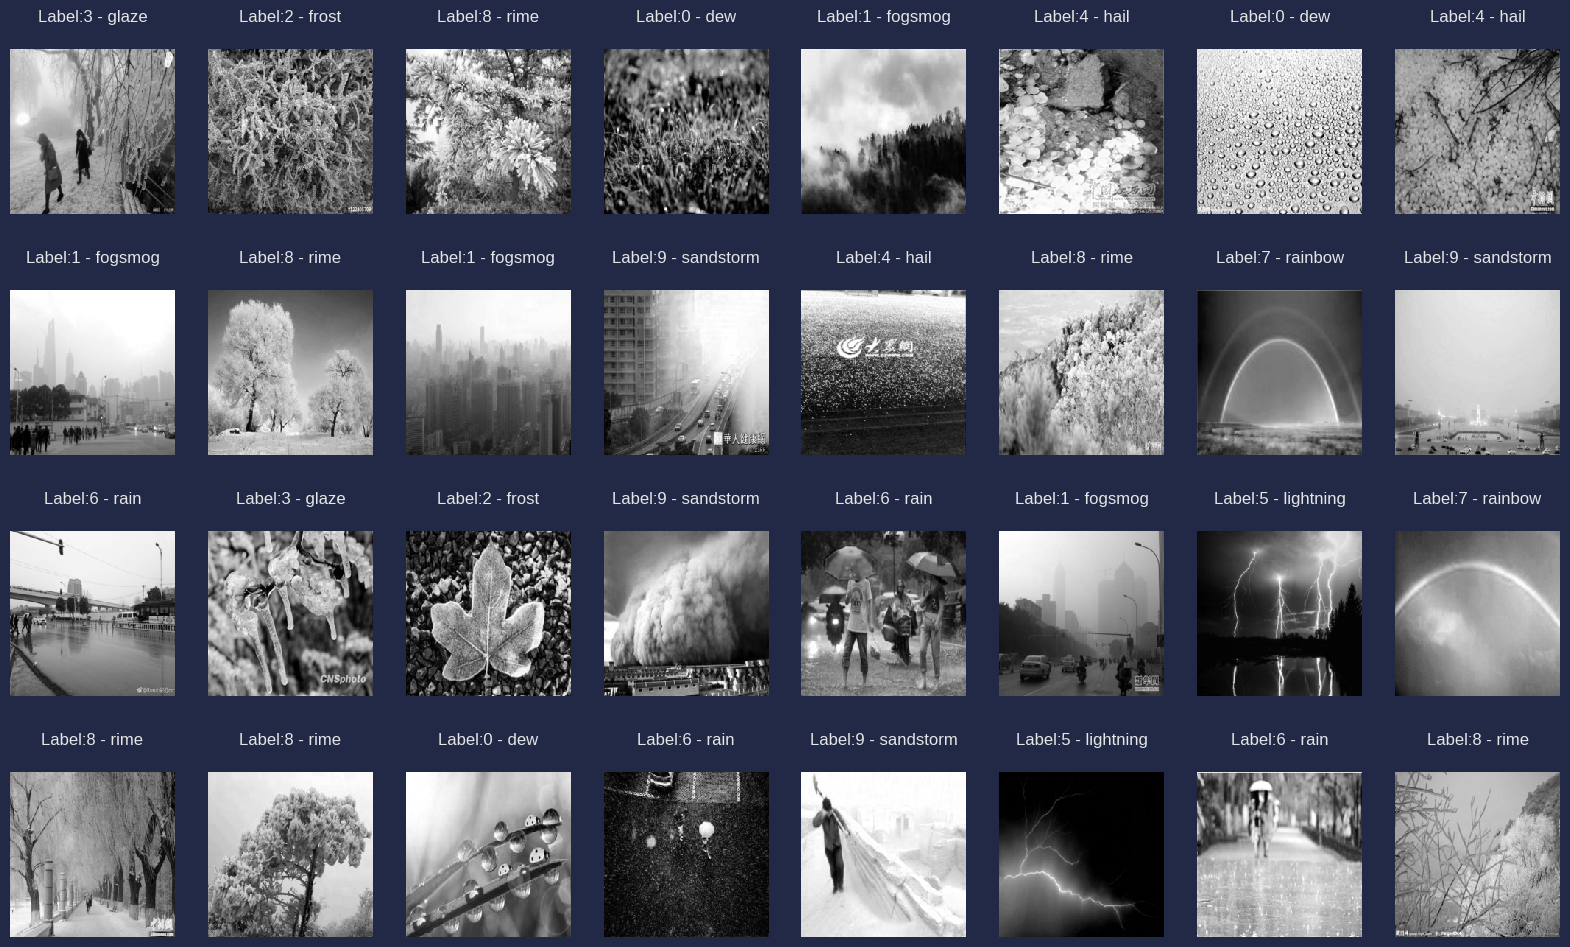

In [9]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels

# распечатаем произвольную картинку
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
batch, labels = get_batch_from_loader(train_loader)
for i, plot in enumerate(ax[:len(batch)]):
    plot.set_title(f'Label:{labels[i]} - {train_loader.dataset.dataset.classes[labels[i].item()]}')
    plot.matshow(batch[i][0, :, :], cmap='gray')
    plot.axis('off')

Посмотрим на размерности ещё раз

In [10]:
for batch_1, batch_2 in train_loader:
    print(f'Размер данных {batch_1.shape}')
    break

Размер данных torch.Size([256, 3, 224, 224])


#### Подгружаем модельку

In [11]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [12]:
# Посмотрим на структуру модели
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Заменим выходной слой

model.fc = nn.Linear(512, 11)

In [14]:
# Заморозим слои модели, чтобы применит все изменения, которые нам нужны

for param in model.parameters():
    param.requires_grad = False

In [15]:
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [16]:
# Посмотрим, что у нас будет тренироваться, а что останется нетронутым

for i, params in model.named_parameters():
    print(f"{i}: {'Будем тренировать' if params.requires_grad else 'ЗАМОРОЖЕНО'}")

conv1.weight: ЗАМОРОЖЕНО
bn1.weight: ЗАМОРОЖЕНО
bn1.bias: ЗАМОРОЖЕНО
layer1.0.conv1.weight: ЗАМОРОЖЕНО
layer1.0.bn1.weight: ЗАМОРОЖЕНО
layer1.0.bn1.bias: ЗАМОРОЖЕНО
layer1.0.conv2.weight: ЗАМОРОЖЕНО
layer1.0.bn2.weight: ЗАМОРОЖЕНО
layer1.0.bn2.bias: ЗАМОРОЖЕНО
layer1.1.conv1.weight: ЗАМОРОЖЕНО
layer1.1.bn1.weight: ЗАМОРОЖЕНО
layer1.1.bn1.bias: ЗАМОРОЖЕНО
layer1.1.conv2.weight: ЗАМОРОЖЕНО
layer1.1.bn2.weight: ЗАМОРОЖЕНО
layer1.1.bn2.bias: ЗАМОРОЖЕНО
layer2.0.conv1.weight: ЗАМОРОЖЕНО
layer2.0.bn1.weight: ЗАМОРОЖЕНО
layer2.0.bn1.bias: ЗАМОРОЖЕНО
layer2.0.conv2.weight: ЗАМОРОЖЕНО
layer2.0.bn2.weight: ЗАМОРОЖЕНО
layer2.0.bn2.bias: ЗАМОРОЖЕНО
layer2.0.downsample.0.weight: ЗАМОРОЖЕНО
layer2.0.downsample.1.weight: ЗАМОРОЖЕНО
layer2.0.downsample.1.bias: ЗАМОРОЖЕНО
layer2.1.conv1.weight: ЗАМОРОЖЕНО
layer2.1.bn1.weight: ЗАМОРОЖЕНО
layer2.1.bn1.bias: ЗАМОРОЖЕНО
layer2.1.conv2.weight: ЗАМОРОЖЕНО
layer2.1.bn2.weight: ЗАМОРОЖЕНО
layer2.1.bn2.bias: ЗАМОРОЖЕНО
layer3.0.conv1.weight: ЗАМОРОЖЕНО
layer3.0

In [17]:
# Выделим одну картинку
test_batch = next(iter(valid_loader))
test_samples, _ = test_batch
# Получим сводную информацию о модели
tu.get_model_summary(model.to(DEVICE), test_samples[1].unsqueeze(0).to(DEVICE))

Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                              [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                -   [1, 64, 112, 112]           0             0
3_maxpool                                             -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
5_layer1.0.BatchNorm2d_bn1                         [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                  -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                         [64]     [1, 64, 56, 56]       

#### Создадим новый optimizer для последнего слоя, напишем функцию fit() для модели

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
def fit(
        model: torch.nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        history = None,
        criterion=criterion,
        ) -> tuple[list, ...]:

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_accs'])

    for epoch in range(start_epoch+1, start_epoch+n_epochs+1):
        
        print(f'{"-"*11} Epoch {epoch}/{n_epochs} {"-"*11}')

        model.train()
        batch_accs = []
        batch_losses = [] 

        for images, labels in train_loader:
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        model.eval()

        batch_losses = []
        batch_accs = []

        for images, labels in valid_loader:

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():
                y_pred = model(images.to(DEVICE))
            
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history

#### Начнём обучение, сразу посмотрим на метрики, затем построим графики


In [21]:
res_weather = fit(model=model, n_epochs=5, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion)

----------- Epoch 1/5 -----------
train: accuracy 0.2564, loss 2.1719
valid: accuracy 0.4454, loss 1.8468
-----------------------------------

----------- Epoch 2/5 -----------
train: accuracy 0.5846, loss 1.5557
valid: accuracy 0.6305, loss 1.3524
-----------------------------------

----------- Epoch 3/5 -----------
train: accuracy 0.7103, loss 1.1873
valid: accuracy 0.7268, loss 1.0725
-----------------------------------

----------- Epoch 4/5 -----------
train: accuracy 0.7743, loss 0.9654
valid: accuracy 0.7813, loss 0.8976
-----------------------------------

----------- Epoch 5/5 -----------
train: accuracy 0.8039, loss 0.8339
valid: accuracy 0.8051, loss 0.7996
-----------------------------------



Достаточно неплохая точность, попробуем ещё 5 эпох добавить


In [22]:
res_weather_10e = fit(model=model, n_epochs=5, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather)

----------- Epoch 6/5 -----------
train: accuracy 0.8225, loss 0.7387
valid: accuracy 0.8205, loss 0.7374
-----------------------------------

----------- Epoch 7/5 -----------
train: accuracy 0.8334, loss 0.6742
valid: accuracy 0.8286, loss 0.6797
-----------------------------------

----------- Epoch 8/5 -----------
train: accuracy 0.8419, loss 0.6266
valid: accuracy 0.8255, loss 0.6555
-----------------------------------

----------- Epoch 9/5 -----------
train: accuracy 0.8466, loss 0.5939
valid: accuracy 0.8385, loss 0.6051
-----------------------------------

----------- Epoch 10/5 -----------
train: accuracy 0.8530, loss 0.5637
valid: accuracy 0.8374, loss 0.5800
-----------------------------------



In [23]:
res_weather_20e = fit(model=model, n_epochs=10, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather_10e)

----------- Epoch 11/10 -----------
train: accuracy 0.8573, loss 0.5313
valid: accuracy 0.8472, loss 0.5636
-----------------------------------

----------- Epoch 12/10 -----------
train: accuracy 0.8623, loss 0.5109
valid: accuracy 0.8430, loss 0.5553
-----------------------------------

----------- Epoch 13/10 -----------
train: accuracy 0.8645, loss 0.4927
valid: accuracy 0.8452, loss 0.5438
-----------------------------------

----------- Epoch 14/10 -----------
train: accuracy 0.8696, loss 0.4773
valid: accuracy 0.8495, loss 0.5164
-----------------------------------

----------- Epoch 15/10 -----------
train: accuracy 0.8732, loss 0.4607
valid: accuracy 0.8552, loss 0.5093
-----------------------------------

----------- Epoch 16/10 -----------
train: accuracy 0.8748, loss 0.4464
valid: accuracy 0.8409, loss 0.5043
-----------------------------------

----------- Epoch 17/10 -----------
train: accuracy 0.8799, loss 0.4331
valid: accuracy 0.8549, loss 0.4831
----------------------

In [24]:
res_weather_30e = fit(model=model, n_epochs=10, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather_20e)

----------- Epoch 21/10 -----------
train: accuracy 0.8866, loss 0.3977
valid: accuracy 0.8556, loss 0.4668
-----------------------------------

----------- Epoch 22/10 -----------
train: accuracy 0.8904, loss 0.3860
valid: accuracy 0.8553, loss 0.4652
-----------------------------------

----------- Epoch 23/10 -----------
train: accuracy 0.8885, loss 0.3808
valid: accuracy 0.8523, loss 0.4704
-----------------------------------

----------- Epoch 24/10 -----------
train: accuracy 0.8920, loss 0.3787
valid: accuracy 0.8543, loss 0.4581
-----------------------------------

----------- Epoch 25/10 -----------
train: accuracy 0.8921, loss 0.3677
valid: accuracy 0.8563, loss 0.4547
-----------------------------------

----------- Epoch 26/10 -----------
train: accuracy 0.8918, loss 0.3657
valid: accuracy 0.8653, loss 0.4431
-----------------------------------

----------- Epoch 27/10 -----------
train: accuracy 0.8952, loss 0.3563
valid: accuracy 0.8603, loss 0.4365
----------------------

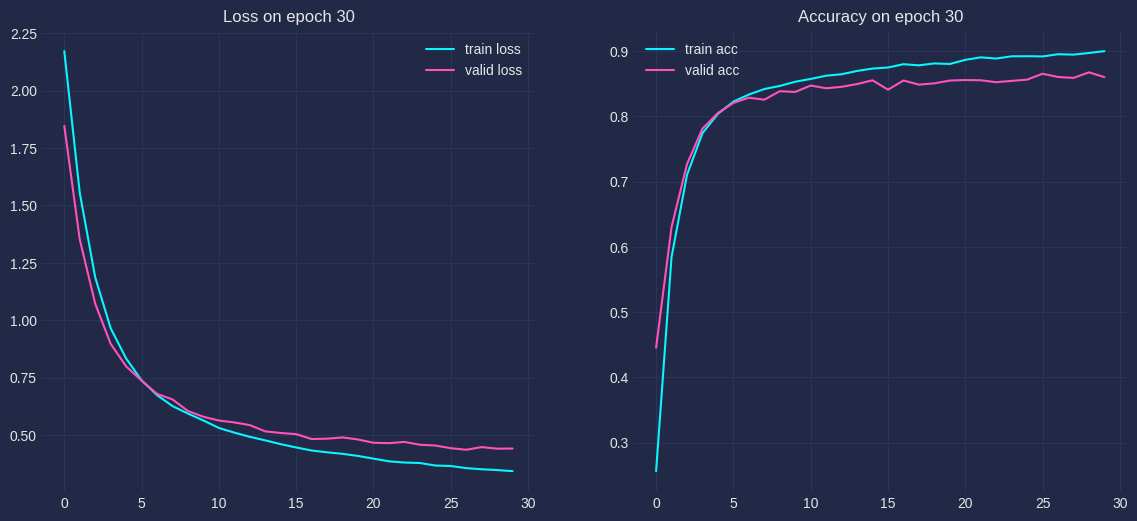

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6)) # type:ignore 

ax[0].plot(res_weather_30e['train_losses'], label='train loss')
ax[0].plot(res_weather_30e['valid_losses'], label='valid loss')
ax[0].set_title(f'Loss on epoch {len(res_weather_30e["train_losses"])}')
#ax[0].set_ylim((0.35, 0.55))
ax[0].legend()

ax[1].plot(res_weather_30e['train_accs'], label='train acc')
ax[1].plot(res_weather_30e['valid_accs'], label='valid acc')
ax[1].set_title(f'Accuracy on epoch {len(res_weather_30e["train_losses"])}')
#ax[1].set_ylim((0.75, 0.9))
ax[1].legend()

plt.show()

#### Время не выводил, в последствии буду записывать время работы в отдельную переменную, либо вывод в "консоль"

In [ ]:
TRUE == 

In [31]:
time_seg = [
    (5, 5*60 + 51.3),     # Первые 5 эпох, прогнанные через модель за время, которое указано выше
    (5, 5 * 60 + 23),   # Вторые 5 эпох
    (10, 9 * 60 + 39.2),    # Третья итерация обучения, + 10 эпох
    (10, 9 * 60 + 38.3)     # Последние 10 эпох
]

num_epochs = []
cumulative_time = 0
times = []

for epochs, time in time_seg:
    for _ in range(epochs):
        cumulative_time += time / epochs
        times.append(cumulative_time)
        num_epochs.append(len(num_epochs) + 1)

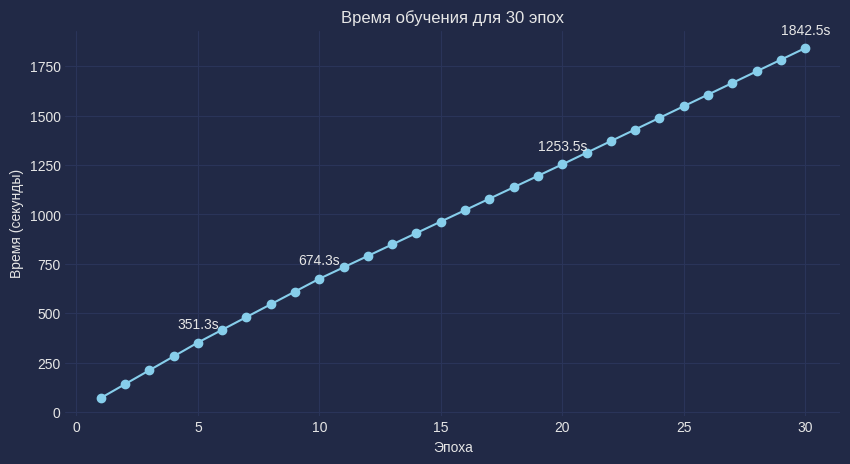

In [27]:
# Строим график времени

plt.figure(figsize=(10, 5))
plt.plot(num_epochs, times, marker='o', color='skyblue')
plt.title(f'Время обучения для {max(num_epochs)} эпох')
plt.xlabel('Эпоха')
plt.ylabel("Время (секунды)")
plt.grid(True)

for i, txt in enumerate(times):
    if i in [4, 9, 19, 29]:  # Ключевые точки, 5, 10, 20 и 30 эпохи соответственно
        plt.annotate(f'{txt:.1f}s', (num_epochs[i], times[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

In [28]:
model_weights = '../models/resnet_weather_weights_2.pt'

torch.save(model.state_dict(), model_weights)

In [ ]:
TRUE == 

In [ ]:
#model.load_state_dict(torch.load("../models/resnet_weather_weights.pt", map_location=DEVICE))
#model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
def metrics(model, valid_dataloader, device):
    model.eval()

    # Метрики
    accuracy_batch = []
    precision_batch = []
    recall_batch = []
    f1_batch = []

    conf_matrix = torch.zeros((11, 11), dtype=torch.int64, device="cpu")

    with torch.no_grad():
        for img, label in valid_dataloader:
            img, label = img.to(device), label.to(device)

            output = model(img)
            preds = torch.argmax(output, dim=1)

            # Accuracy
            accuracy = (preds == label).float().mean().item()
            accuracy_batch.append(accuracy)

            # Confusion Matrix (на CPU)
            for true, pred in zip(label.cpu(), preds.cpu()):
                conf_matrix[true, pred] += 1

            # Очистка памяти
            del img, label, output, preds
            torch.cuda.empty_cache()

    # Считаем метрики на основе полной матрицы
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=0) - TP
    FN = conf_matrix.sum(dim=1) - TP

    precision = (TP / (TP + FP + 1e-10)).mean().item()
    recall = (TP / (TP + FN + 1e-10)).mean().item()
    f1 = (2 * precision * recall) / (precision + recall + 1e-10)

    # Усреднение метрик
    acc = np.mean(accuracy_batch)

    result = {
        'ACCURACY': acc,
        'PRECISION': precision,
        'RECALL': recall,
        'F1': f1,
        'CONFUSION MATRIX': conf_matrix
    }

    return result

In [35]:
out = metrics(model=model, valid_dataloader=valid_loader, device=DEVICE)

In [36]:
out

{'ACCURACY': np.float64(0.8646965622901917),
 'PRECISION': 0.8701854944229126,
 'RECALL': 0.8588853478431702,
 'F1': 0.864498495669231,
 'CONFUSION MATRIX': tensor([[141,   1,   2,   6,   1,   1,   2,   0,   0,   0,   0],
         [  0, 131,   0,   0,   0,   0,   1,   3,   2,   9,   5],
         [  1,   1,  67,  11,   2,   0,   0,   0,   7,   0,   2],
         [  0,   0,  10,  91,   2,   0,   0,   0,  21,   0,   3],
         [  1,   0,   0,   2, 102,   0,   0,   0,   0,   0,   2],
         [  0,   3,   0,   0,   0,  80,   0,   1,   1,   0,   0],
         [  0,   3,   0,   3,   3,   0,  93,   0,   0,   2,   6],
         [  1,   0,   0,   0,   0,   0,   0,  40,   2,   1,   0],
         [  0,   0,   3,  13,   0,   0,   0,   0, 219,   1,   5],
         [  0,  11,   0,   1,   0,   0,   1,   0,   1, 126,   0],
         [  0,   1,   3,   6,   5,   0,   2,   0,  13,   0,  92]])}

In [41]:
def get_metrics(model, valid_dataloader, device):
    model.eval()
    model.to(device)

    # Метрики по батчам
    accuracy_batch = []
    precision_batch = []
    recall_batch = []
    f1_batch = []
    conf_matrix = torch.zeros((11, 11), dtype=torch.int64)  # Assumes 11 classes

    with torch.no_grad():
        for img, label in valid_dataloader:
            img, label = img.to(device), label.to(device)

            # Получаем выходы модели
            output = model(img)
            
            # Предсказания
            preds = torch.argmax(output, dim=1)
            
            # Проверка на соответствие размеров
            assert preds.shape[0] == label.shape[0], f"Size mismatch: preds {preds.shape}, label {label.shape}"
            
            # Accuracy
            accuracy = (preds == label).float().mean().item()
            accuracy_batch.append(accuracy)

            # Confusion Matrix
            for true, pred in zip(label.cpu(), preds.cpu()):
                conf_matrix[true, pred] += 1

            # Precision, Recall, F1 для текущего батча
            TP = torch.diag(conf_matrix)
            FP = conf_matrix.sum(dim=0) - TP
            FN = conf_matrix.sum(dim=1) - TP

            precision = (TP / (TP + FP + 1e-10)).mean().item()
            recall = (TP / (TP + FN + 1e-10)).mean().item()
            f1 = (2 * precision * recall) / (precision + recall + 1e-10)

            precision_batch.append(precision)
            recall_batch.append(recall)
            f1_batch.append(f1)

            # Очистка памяти
            del img, label, output, preds
            torch.cuda.empty_cache()

    # Усреднение метрик по батчам
    acc = sum(accuracy_batch) / len(accuracy_batch)
    prec = sum(precision_batch) / len(precision_batch)
    rec = sum(recall_batch) / len(recall_batch)
    f1_score = sum(f1_batch) / len(f1_batch)

    # Фиксируем прибыль
    result = {
        'ACCURACY': acc,
        'PRECISION': prec,
        'RECALL': rec,
        'F1': f1_score,
        'CONFUSION MATRIX': conf_matrix
    }

    return result, accuracy_batch, precision_batch, recall_batch, f1_batch, conf_matrix

In [42]:
out1, acc_b, p_b, r_b, f1_b, cm = get_metrics(model=model, valid_dataloader=valid_loader, device=DEVICE)

In [43]:
out1

{'ACCURACY': 0.8623754580815634,
 'PRECISION': 0.8643834988276163,
 'RECALL': 0.8489861488342285,
 'F1': 0.8566119154958333,
 'CONFUSION MATRIX': tensor([[141,   1,   2,   6,   1,   1,   2,   0,   0,   0,   0],
         [  0, 131,   0,   0,   0,   0,   1,   3,   2,   9,   5],
         [  1,   1,  67,  11,   2,   0,   0,   0,   7,   0,   2],
         [  0,   0,  10,  91,   2,   0,   0,   0,  21,   0,   3],
         [  1,   0,   0,   2, 102,   0,   0,   0,   0,   0,   2],
         [  0,   3,   0,   0,   0,  80,   0,   1,   1,   0,   0],
         [  0,   3,   0,   3,   3,   0,  93,   0,   0,   2,   6],
         [  1,   0,   0,   0,   0,   0,   0,  40,   2,   1,   0],
         [  0,   0,   3,  13,   0,   0,   0,   0, 219,   1,   5],
         [  0,  11,   0,   1,   0,   0,   1,   0,   1, 126,   0],
         [  0,   1,   3,   6,   5,   0,   2,   0,  13,   0,  92]])}

In [62]:
def plot_metrics(accuracy_batch, precision_batch, recall_batch, f1_batch, conf_matrix):
    
    # Графики по метрикам
    plt.figure(figsize=(10, 5))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(accuracy_batch, label='Accuracy')
    plt.title('Accuracy в Батчах')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 2)
    plt.plot(precision_batch, label='Precision', color='orange')
    plt.title('Precision в Батчах')
    plt.xlabel('Batch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 3)
    plt.plot(recall_batch, label='Recall', color='g')
    plt.title('Recall в Батчах')
    plt.xlabel('Batch')
    plt.ylabel('Recall')
    plt.legend()

    # F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(f1_batch, label='F1 Score', color='r')
    plt.title('F1 Score в Батчах')
    plt.xlabel('Batch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix.cpu().numpy(), annot=True, fmt='d')
    plt.title('Тепловая карта матрицы корреляций')
    plt.xlabel('Предсказанные Классы')
    plt.ylabel('Правильные Классы')
    plt.show()


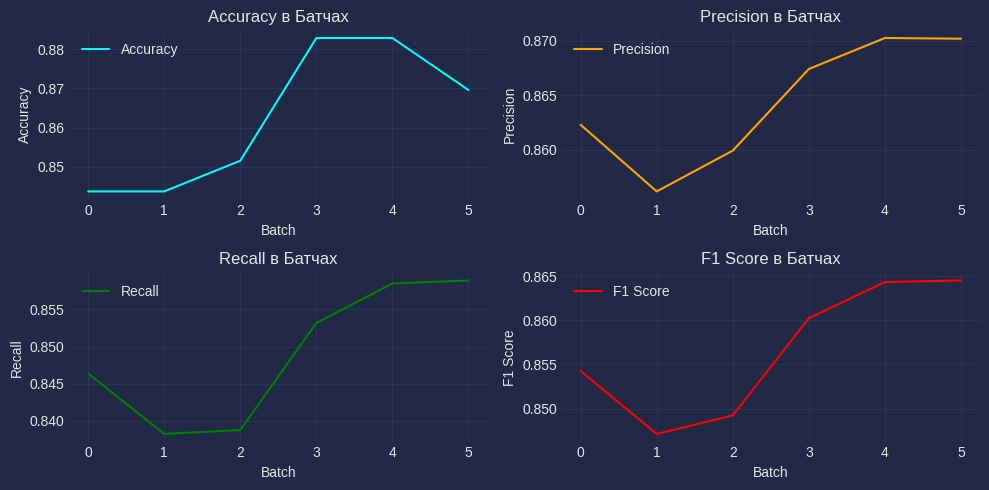

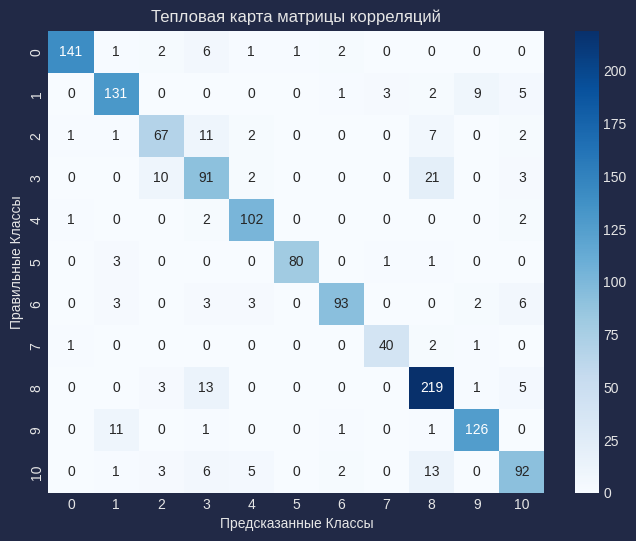

In [63]:
plot_metrics(acc_b, p_b, r_b, f1_b, cm)

#### Так получается, что написал функцию для бачей, что в целом тоже интересно, приятно отслеживать метрику в бачах


In [65]:
#### Немного перепишем функцию, чтобы смотреть графики по эпохам, а не батчам

def get_epoch_metrics(model, dataloader, device, n_epochs, history=None):
    model.to(device)

    # Если передана история, используем её; если нет, создаём новую
    if history is None:
        history = {
            'accuracy': [],
            'f1': [],
            'conf_matrix': []
        }

    for epoch in range(n_epochs):
        model.eval()

        accuracy_batch = []
        conf_matrix = torch.zeros((11, 11), dtype=torch.int64, device=device)

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                # Accuracy
                accuracy = (preds == labels).float().mean().item()
                accuracy_batch.append(accuracy)

                # Confusion Matrix
                for true, pred in zip(labels.cpu(), preds.cpu()):
                    conf_matrix[true, pred] += 1

            # Calculate F1 Score
            TP = torch.diag(conf_matrix)
            FP = conf_matrix.sum(dim=0) - TP
            FN = conf_matrix.sum(dim=1) - TP

            precision = (TP / (TP + FP + 1e-10)).mean().item()
            recall = (TP / (TP + FN + 1e-10)).mean().item()
            f1 = (2 * precision * recall) / (precision + recall + 1e-10)

            history['accuracy'].append(np.mean(accuracy_batch))
            history['f1'].append(f1)
            history['conf_matrix'].append(conf_matrix.cpu().numpy())

    return history

In [71]:
rab = get_epoch_metrics(model=model, dataloader=valid_loader, device=DEVICE, n_epochs=15)#, history=res_weather_30e)

In [72]:
def plot_epoch_metrics(history):
    """
    Построение графиков метрик на обученной модели за несколько эпох
    """
    epochs = range(1, len(history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], marker='o', label='Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['f1'], marker='o', color='red', label='F1')
    plt.title('F1 per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

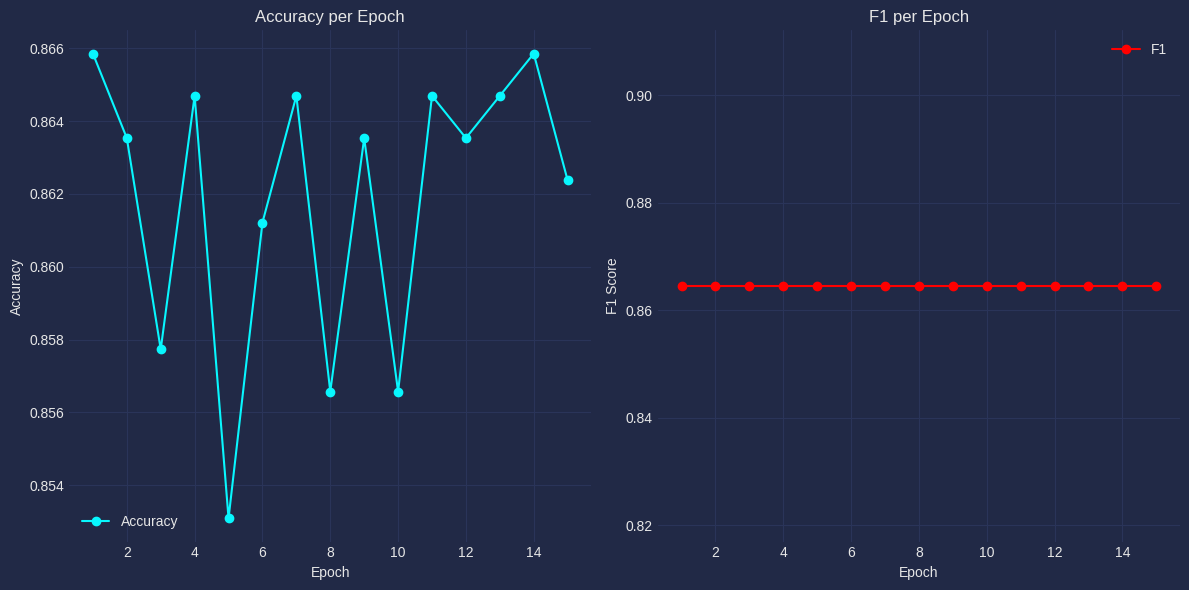

In [73]:
plot_epoch_metrics(rab)